In [3]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
from matplotlib.pyplot import plot
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import math

In [4]:
def show_images(images, size=(16, 8), mode='grayscale', dpi=150, image_type=None, grid=None, title=None, fig_suptitle=None, BGR=False): 
        if not isinstance(images, tuple) and not isinstance(images, list):
            images = [images]
            title = [title]
            grid = (1, 1)
        if isinstance(mode, tuple) or isinstance(mode, list):
            change_mode = True
        else:
            current_mode = mode
            change_mode = False
        
        if isinstance(image_type, tuple) or isinstance(image_type, list):
            change_mode_type = True
        else:
            current_mode_type = image_type
            change_mode_type = False
        
        if not grid:
            grid = []
            grid.append(math.ceil(len(images) / 2))
            grid.append(1)
            
        fig=plt.figure(figsize=size, dpi=dpi)
        for i, img in enumerate(images):
            if BGR:
                try:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                except:
                    continue
            fig.add_subplot(grid[0], grid[1], i+1)

            if change_mode:
                current_mode = mode[i]
            if change_mode_type:
                current_mode_type = image_type[i]

            if current_mode=='grayscale':
                if current_mode_type=='spectrum':
                    plt.imshow(np.abs(img)**(0.1), cmap='gray')
                else:
                    plt.imshow(img, cmap='gray')
            else:
                if current_mode_type=='spectrum':
                    plt.imshow(np.abs(img)**(0.1))
                else:
                    plt.imshow(img)
                    
            if title and title[i] is not None:
                plt.title(title[i], fontsize=14)
            plt.axis('off')
        if fig_suptitle:
            fig.suptitle(fig_suptitle, fontsize=20)
        plt.show()

In [5]:
def normalize_image(np_img, mul_const=1.0):
    return (mul_const * (np_img-np_img.min()) / (np_img.max() - np_img.min()))

def cut_img_values(img):
    img_copy = img
    img_copy[img_copy < 0] = 0
    img_copy[img_copy > 255] = 255
    return img_copy

def image_transforms(img):
    # (a) Исходное изображение
    # (б) Применение оператора лапласиана к изображению
    # ddepth: S - signed, U - unsigned 
    laplassian_img_cut = cut_img_values(cv2.Laplacian(255-img, ddepth=cv2.CV_16U, ksize=3))
    
    laplassian_img = normalize_image(cv2.Laplacian(img, ddepth=cv2.CV_16U, ksize=3), 255.0).astype("int")
    laplassian_img = (255 * np.power(laplassian_img / 255, 0.5)).astype("uint8")
    
    # (в) Повышение резкости сложением изображений (а) и (б)
    laplassian_img_add = normalize_image(img + laplassian_img_cut, 255.0).astype("uint8")

    # (г) Применение градиентного оператора Собела к изображению (а)
    sobel_via_x = cv2.Sobel(img, ddepth=cv2.CV_16U, dx=1, dy=0)
    sobel_via_y = cv2.Sobel(img, ddepth=cv2.CV_16U, dx=0, dy=1)
    sobel = np.absolute(sobel_via_x) + np.absolute(sobel_via_y)
    sobel_img = cut_img_values(img + sobel)
    
    # (д) Изображение (г), сглаженное усредняющим фильтром по окрестности 5×5.
    sobel_blur = cv2.blur(sobel_img, (5, 5))
    
    # (е) Изображение-маска, полученное перемножением изображений (в) и (д)
    laplassian_blur_sobel_mask = normalize_image(
        cv2.multiply(laplassian_img_add, sobel_blur, dtype=cv2.CV_16U), 255.0).astype(int)
    
    # (ж) Изображение с повышенной резкостью, полученное сложением изображений (а) и (е).
    orig_laplassian_blur_sobel_mask = cut_img_values(img + laplassian_blur_sobel_mask)
    
    # (з) Конечный результат, полученный из изображения (ж) градационной коррекцией по степенному закону
    final_res = (255 * np.power(orig_laplassian_blur_sobel_mask / 255, 2.5)).astype("uint8")
    
    return (
        img,
        laplassian_img,
        laplassian_img_add,
        sobel_img,
        sobel_blur,
        laplassian_blur_sobel_mask,
        orig_laplassian_blur_sobel_mask,
        final_res
    )

# Начальная инициализация

In [6]:
# Загружаем начальные изображения
image_path = "coins.jpg"
image_path_2 = "coins2.jpg"
image_1 = cv2.imread(image_path)
image_2 = cv2.imread(image_path_2)

images = (image_1, image_2)

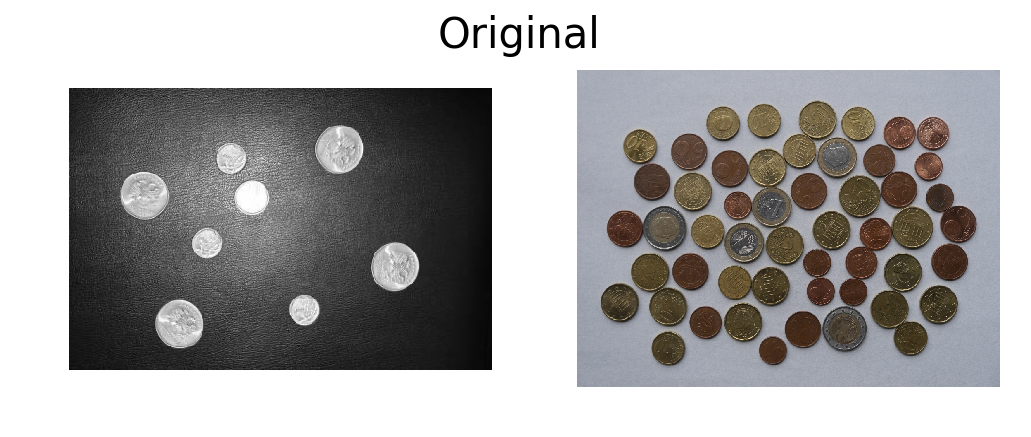

In [7]:
show_images(
    images, 
    grid=(1,2),
    size=(8,3), 
    BGR = True,
    fig_suptitle = "Original"
)

# Применение алгоритма среднего сдвига

In [8]:
shifted_images = []
for image in images:
    shifted = (255 * np.power(cv2.pyrMeanShiftFiltering(image, 21, 51) / 255, 1.2)).astype("uint8")
    shifted_images.append(shifted)

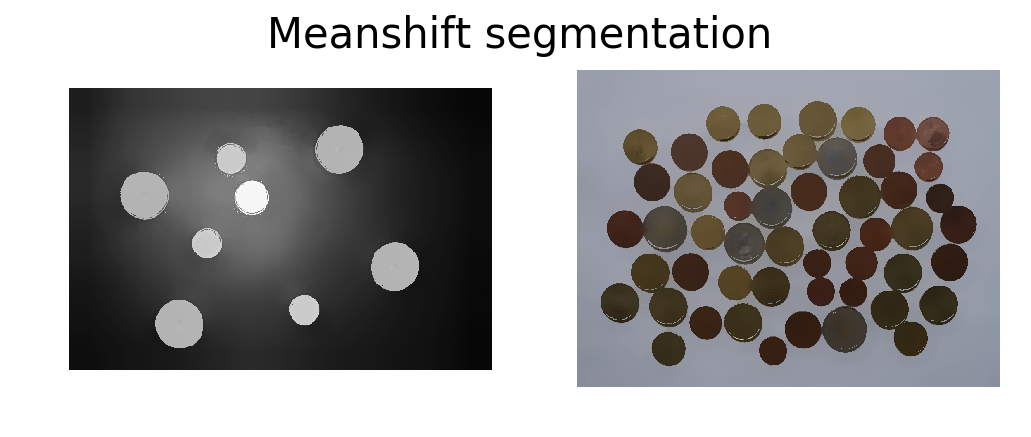

In [9]:
show_images(
    shifted_images, 
    fig_suptitle = "Meanshift segmentation",
    grid=(1,2),
    size=(8,3),  
    BGR = True
)

# Применение пространственной фильтрации

In [10]:
transformed_images = []
for shifted in shifted_images:
    transformed_images.append(image_transforms(shifted))

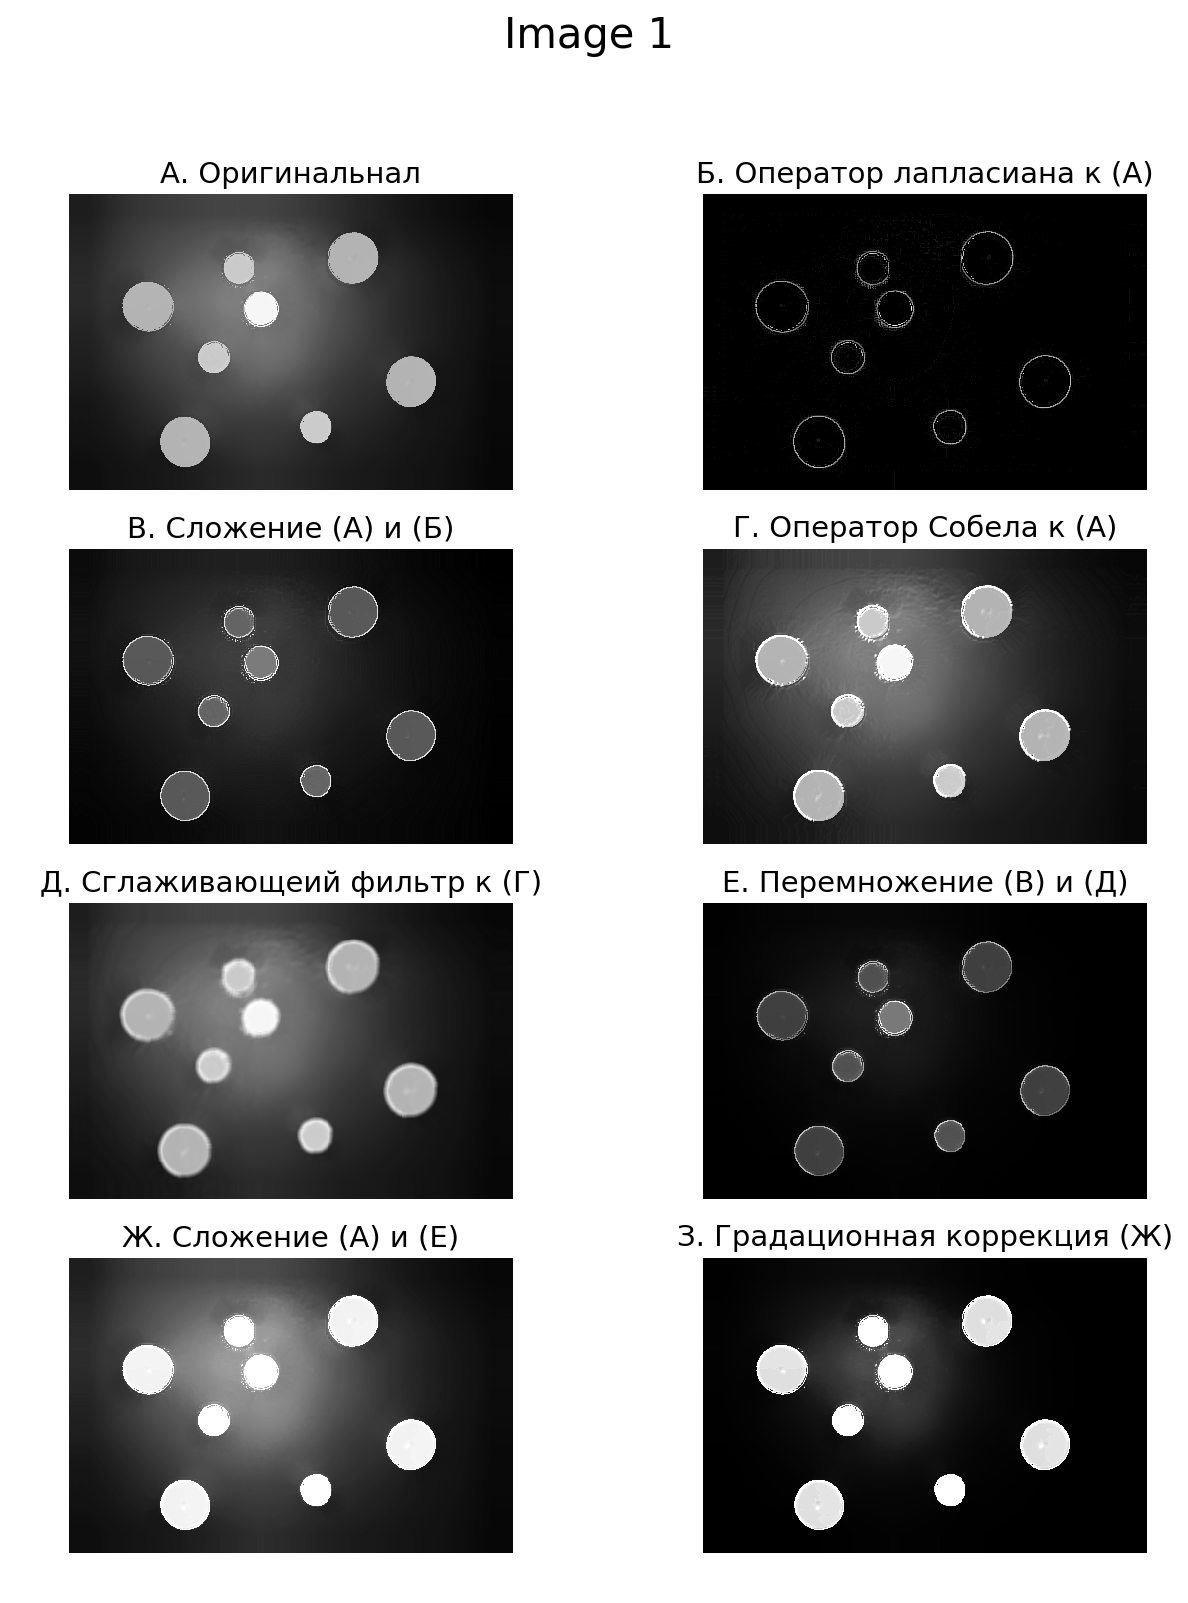

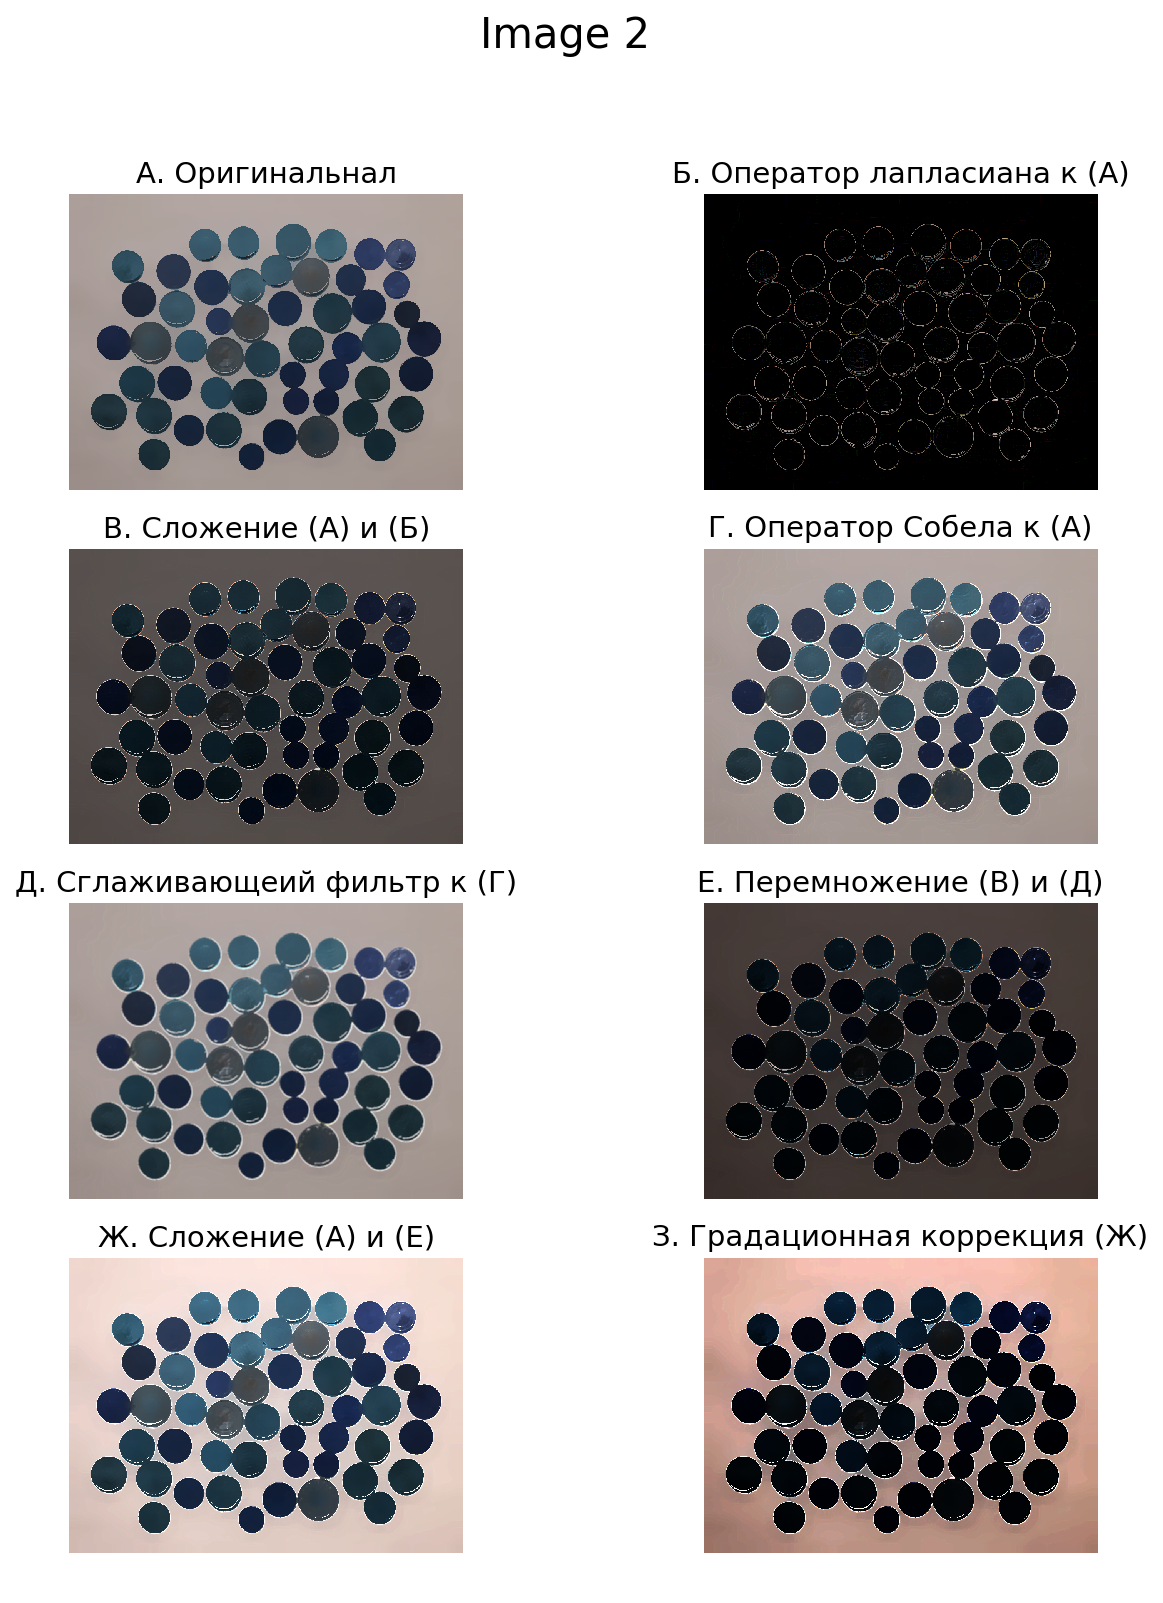

In [11]:
titles = (
    "A. Оригинальнал",
    "Б. Оператор лапласиана к (А)",
    "В. Сложение (А) и (Б)",
    "Г. Оператор Собела к (А)",
    "Д. Сглаживающеий фильтр к (Г)",
    "E. Перемножение (В) и (Д)",
    "Ж. Сложение (А) и (Е)",
    "З. Градационная коррекция (Ж)"
)
for i, tranformed in enumerate(transformed_images):
    show_images(
        tranformed, 
        grid=(4,2), 
        title=titles, 
        size=(10,12), 
        fig_suptitle = f"Image {i+1}",
)

# Бинаризация изображения

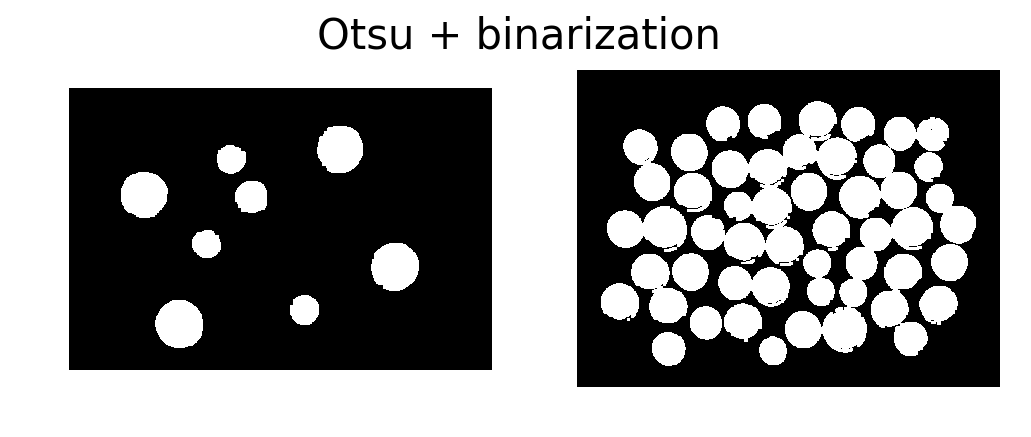

In [15]:
gray_images = []
thresh_images = []
for tranformed in transformed_images:
    # Конвертируем в полутоновое изображение
    gray = cv2.cvtColor(tranformed[7], cv2.COLOR_RGB2GRAY)
    
    # Применяем инверсию в случае, если фон светлый
    if (gray < 100).sum() < gray.size/2:
        BINARY = cv2.THRESH_BINARY_INV
    else:
        BINARY = cv2.THRESH_BINARY
    
    # Применяем бинаризацию и метод Отсу
    thresh = cv2.threshold(
        gray, 60, 255,
        BINARY+cv2.THRESH_OTSU
    )[1]
    
    # Применение эрозии и дилатации для образования разрывов, 2 итерации
    kernel = np.ones((3,3),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations = 3)
    
    # Сохраняем изоображения
    gray_images.append(gray)
    thresh_images.append(thresh)
    
show_images(
    thresh_images, 
    fig_suptitle = "Otsu + binarization",
    grid=(1,2),
    size=(8,3),
)

# Применение метода водоразделов

### Для достижения результата используются дополнительные этапы:
### 1. Подсчет точного Евклидового расстояния
### 2. Поиск локальных максимумов
### 3. Поиск связных компонент, используя 8-связный структурный элемент
### 4. Применение Watershed с использованием найденных компонент в качестве маркеров

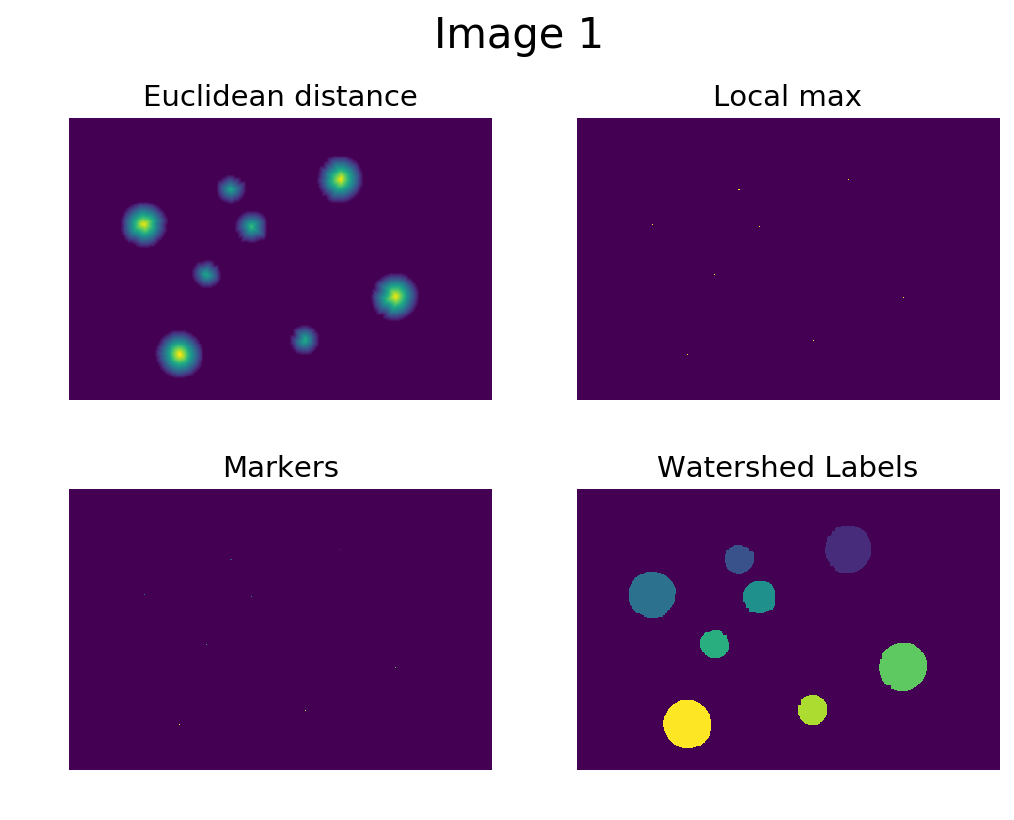

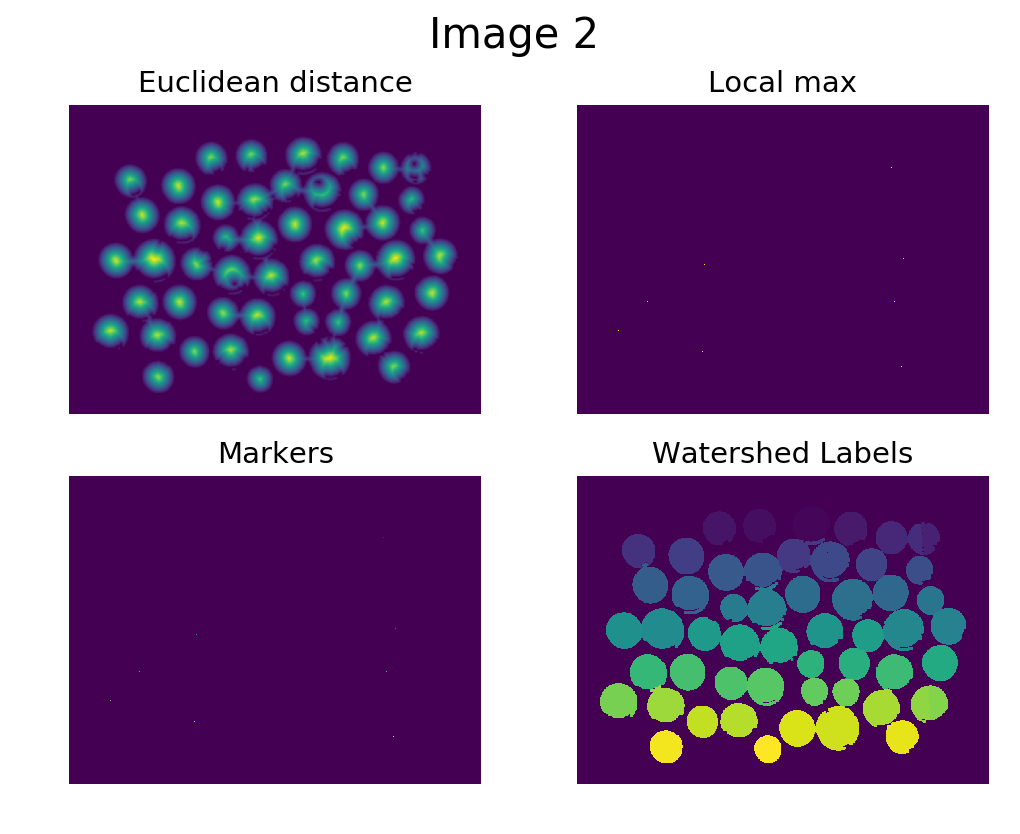

In [16]:
labels_list = []
for i, thresh in enumerate(thresh_images):
    # Точное Евклидово расстояние
    D = ndimage.distance_transform_edt(thresh)
    # Поиск локальных максимумов
    localMax = peak_local_max(D, indices=False, min_distance=13, labels=thresh)

    # Поиск связных компонент
    markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
    # Применение Watershed
    labels = watershed(-D, markers, mask=thresh)
    labels_list.append(labels)
    
    show_images(
        [D, localMax, markers, labels], 
        title=["Euclidean distance", "Local max", "Markers", "Watershed Labels"], 
        mode="rgb", 
        size=(8,6), 
        grid=(2,2),
        fig_suptitle = f"Image {i+1}",

    )

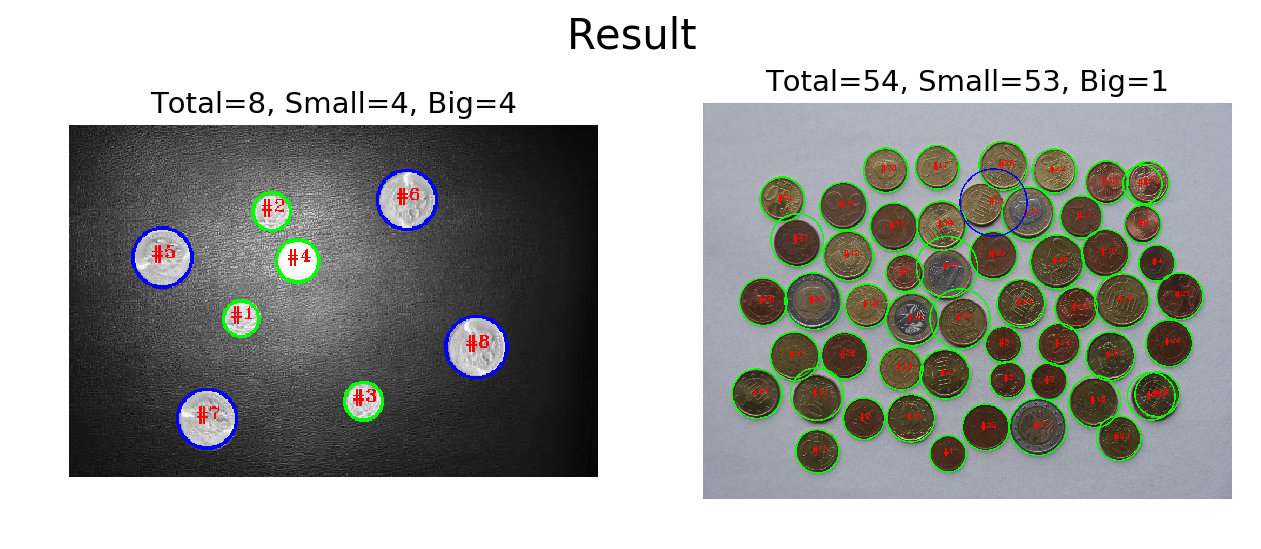

In [17]:
output_images = []
output_titles = []
for i, labels in enumerate(labels_list):
    # Проходим по областям, которые нашел Watershed
    radius_list = []
    coords_list = []
    for label in np.unique(labels):
        # Если нет label, то это фон -> пропускаем
        if label == 0:
            continue
        # Делаем маску по найденным областям
        mask = np.zeros(gray_images[i].shape, dtype="uint8")
        mask[labels == label] = 255
        
        # Определение контуров и выбор наибольшего
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        # Строим минимальное покрывающее кольцо
        ((x, y), r) = cv2.minEnclosingCircle(c)
        
        # Отсекаем мелкие кольца, которые могут возникнуть из-за пересегментации
        # Остальные сохраняем для нанесения
        if r > 15:
            radius_list.append(r)
            coords_list.append((x, y))
            
    # Накопленные радиусы и координаты приводим к np массиву для работы с ними
    radius_list = np.array(radius_list)
    coords_list = np.array(coords_list)
    
    # Сортируем радиусы по возрастанию, получаем соответствующие индексы
    indices = radius_list.argsort()
    # Сортируем массивы по найденным индексам
    radius_list = radius_list[indices[::1]]
    coords_list = coords_list[indices[::1]]
    # Подсчитываем разницу между соседями и сохраняем индекс наибольшего разрыва между элементами
    # Необходимо для определения типа монеты
    border_val_id = np.argmax(np.diff(radius_list)) + 1
        
    # Копируем изображение, чтобы не изменять начальное
    output_image = images[i].copy()
    # Начальный цвет обводки
    color = (0, 255, 0)
    for i, r in enumerate(radius_list):
        (x, y) = coords_list[i]
        # Меняем цвет обводки, когда достигаем элемента с наибольшей разницей с предыдущим
        if i == border_val_id:
            color = (255, 0, 0)
        # Наносим кольцо на изображение
        cv2.circle(output_image, (int(x), int(y)), int(r), color, 2)
        # Наносим текст
        cv2.putText(
            output_image, 
            f"#{i+1}", (int(x) - 10, int(y)),
            cv2.FONT_HERSHEY_TRIPLEX, 
            0.5, (0, 0, 255), 0
        )
    
    # Общее количество монет на изображении
    total_coins = len(radius_list)
    # Сохраняем выходное изображение
    output_images.append(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    # Сохраняем заголовк с информацией о количестве монет
    output_titles.append(
        f"Total={len(radius_list)}, Small={border_val_id}, Big={len(radius_list)-border_val_id}"
    )

# Выводим на экран финальный результат
show_images(
    output_images, 
    title=output_titles, 
    grid=(1,2),
    size=(10,4),
    fig_suptitle="Result"
)